In [1]:
import pandas as pd
from scutquant import scutquant, alpha, executor

In [2]:
# 读取数据并初步加工

df = pd.read_feather('D:/Desktop/q3/q3data.ftr')
df = df.set_index(['time', 'code']).sort_index()
df = df[~df.index.duplicated()]  # 由于存在脏数据，部分索引会重复
df = df.groupby(['code']).fillna(method='ffill').dropna()

df['ret'] = scutquant.price2ret(df['lastPrice'], shift1=-1, shift2=-21, groupby='code')
df.dropna(axis=0, inplace=True)

In [3]:
# 生成因子
factor_config = {
    'data': df,
    'label': 'ret',
    'price': 'lastPrice',
    'last_close': 'lastClose',
    'volume': 'volume',
    'amount': 'amount',
    'high': 'high',
    'low': 'low',
    'groupby': 'code',
    'shift': 21
}
X = alpha.make_factors(factor_config, windows=[5, 10, 20, 30, 60, 120])
data_preprocess = pd.concat([X, df['ret']], axis=1)
data_preprocess = data_preprocess[~data_preprocess.index.duplicated()]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 254511 entries, (Timestamp('2022-10-10 09:30:00'), '000049.SZ') to (Timestamp('2022-10-31 14:56:00'), '601318.SH')
Columns: 127 entries, ma5 to ret
dtypes: float64(127)
memory usage: 250.9+ MB
None
X_mis= 0.05963574366493202
clean dataset done 

pop label done 

label norm done 



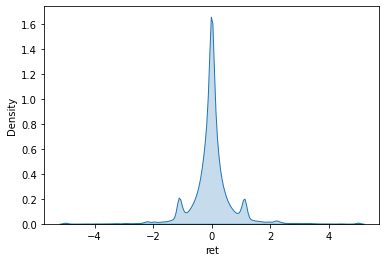

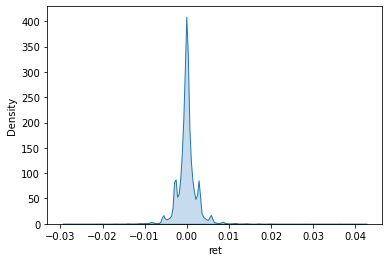

norm data done 

MA5       3.922289
MAX5      3.904654
MIN5      3.903231
MA10      3.801938
MIN10     3.797801
            ...   
vstd10    0.175982
BETA5     0.148971
vma10     0.146993
vma5      0.112109
vstd5     0.098723
Name: MI Scores, Length: 126, dtype: float64
count    126.000000
mean       1.665902
std        1.271412
min        0.098723
25%        0.443429
50%        1.625704
75%        2.947664
max        3.922289
Name: MI Scores, dtype: float64
all works done 



In [4]:
# 数据重采样、标准化、因子正交化、特征选择、数据清洗等
# 使用mutual information score衡量因子质量

x_train, x_test, y_train, y_test, ymean, ystd = scutquant.auto_process(data_preprocess, 'ret', groupby='code')

In [ ]:
#  如果没有qlib，请注释掉这段！
from qlib.contrib.report.data.ana import CombFeaAna, FeaDistAna, FeaNanAnaRatio, FeaInfAna, FeaMeanStd, ValueCNT, FeaACAna, RawFeaAna
from functools import partial
import warnings
warnings.filterwarnings("ignore") #  这是为了忽略掉pandas.plotting的一个无用警告, 修复代码后将移除

feature = x_train.copy()
feature.index.names = ["datetime", "instrument"] 

# 对每个因子输出4张图，从上往下分别是：
    # 因子整体的分布
    # 随着时间变化，因子的均值和方差
    # 随着时间变化，因子每天的 unique value占当天总股票数量的比例（用于统计特征是数值特征还是类别特征）
    # 因子的自相关性 (1 lag)
    
fa_full = CombFeaAna(feature, FeaDistAna, FeaMeanStd, partial(ValueCNT, ratio=True), FeaACAna)
fa_full.plot_all(sub_fs=(5, 2), col_n=5, wspace=0.5)

In [ ]:
#  如果没有qlib，请注释掉这段！
from qlib.contrib.eva.alpha import calc_all_ic

label = y_train.copy()
label.index.names = ["datetime", "instrument"] 
all_ic = calc_all_ic(feature.to_dict('series'), label)
all_ic_df = pd.concat({f: d['ic'] for f, d in all_ic.items()})
all_ic_df = all_ic_df.unstack(0)

# 下图统计了每个特征和Label和IC随时间如何变化 (moving average 100)

fa = RawFeaAna(all_ic_df.rolling(100).mean())
fa.plot_all(sub_fs=(4, 2), col_n=10, wspace=0.5)

In [ ]:
#  如果没有qlib，请注释掉这段！
all_ic_df.mean().plot(kind='bar', figsize=(60, 10))

[0]	validation_0-rmse:1.05655
[1]	validation_0-rmse:1.04658
[2]	validation_0-rmse:1.03712
[3]	validation_0-rmse:1.02890
[4]	validation_0-rmse:1.02151
[5]	validation_0-rmse:1.01432
[6]	validation_0-rmse:1.00762
[7]	validation_0-rmse:1.00160
[8]	validation_0-rmse:0.99608
[9]	validation_0-rmse:0.99076
[10]	validation_0-rmse:0.98589
[11]	validation_0-rmse:0.98114
[12]	validation_0-rmse:0.97740
[13]	validation_0-rmse:0.97389
[14]	validation_0-rmse:0.97029
[15]	validation_0-rmse:0.96736
[16]	validation_0-rmse:0.96431
[17]	validation_0-rmse:0.96191
[18]	validation_0-rmse:0.95944
[19]	validation_0-rmse:0.95706
[20]	validation_0-rmse:0.95502
[21]	validation_0-rmse:0.95352
[22]	validation_0-rmse:0.95177
[23]	validation_0-rmse:0.94992
[24]	validation_0-rmse:0.94861
[25]	validation_0-rmse:0.94737
[26]	validation_0-rmse:0.94593
[27]	validation_0-rmse:0.94444
[28]	validation_0-rmse:0.94311
[29]	validation_0-rmse:0.94169
[30]	validation_0-rmse:0.94067
[31]	validation_0-rmse:0.94012
[32]	validation_0-

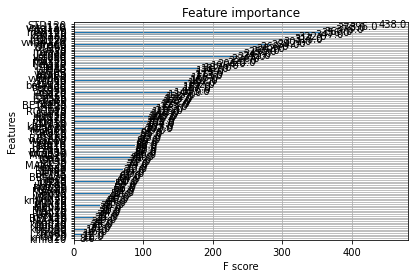

BETA5     0.024858
rsv20     0.019132
MIN60     0.017222
rsv60     0.016196
MAX120    0.015461
            ...   
std5      0.001966
beta5     0.001958
vstd5     0.001822
roc10     0.001416
roc5      0.001028
Length: 126, dtype: float32 

Linear Model Coef:
MAX30    4.317301
MAX20    2.270913
MAX5     1.452568
MIN5     1.359945
MIN60    1.312966
           ...   
MIN30   -1.400831
MIN20   -1.938885
MA60    -2.120044
MAX60   -4.956788
MA120   -6.799579
Length: 126, dtype: float64


In [5]:
# 训练模型，包括配置参数、训练和解释模型

xgb_params = {
    'est': 800,
    'eta': 0.0421,
    'colsamp': 0.8875,
    'subsamp': 0.8725,
    'max_depth': 10,
    'l1': 45,
    'l2': 50,
    'early_stopping_rounds': 20
}
model = scutquant.hybrid(lrg_method='ridge', xgb_params=xgb_params, weight=[0.1, 0.9])
model.fit(x_train, y_train, x_test, (y_test-ymean)/ystd)
model.explain_model(index=x_test.columns)

In [6]:
# 得到预测值

pred_train = model.predict(x_train)
pred_train = pd.DataFrame({'predict': pred_train}, index=x_train.index)
pred_train += ymean
pred_train *= ystd

pred_test = model.predict(x_test)
pred_test = pd.DataFrame({'predict': pred_test}, index=x_test.index)
pred_test += ymean
pred_test *= ystd

pred = pd.concat([pred_train, pred_test], axis=0)

In [7]:
# 此处仅使用测试集数据进行IC分析

ic, icir, rank_ic, rank_icir = scutquant.ic_ana(pred_test, y_test, groupby='time', plot=False)
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)

ic= 0.061769260566407254 icir= 0.085363701774785 rank_ic= 0.05234923862338632 rank_icir= 0.07710222612922749


In [8]:
# 将数据整理成executor要求的样子（索引为多重索引[('time', 'code')], 数据的列名包括 'predict'、't' 和 'price'）

df1 = df[df.index.isin(pred.index)]
df1 = df1.reset_index()
df1['t'] = df1['time']
df1 = df1.set_index(['time', 'code']).sort_index()

pred['t'] = df1['t']  # 上个版本是'time'，现在改成't'
pred['price'] = df1['lastPrice']

In [9]:
# 分别对应有底仓和无底仓的情况, 一般都采用无底仓模式
"""
# 有底仓的情况
acc = {
    'cash': 4000000,
    'position': {'601318.SH': 36100, '002303.SZ': 470200, '000049.SZ': 36100, '000333.SZ': 30400},
    'available': {'601318.SH': 36100, '002303.SZ': 470200, '000049.SZ': 36100, '000333.SZ': 30400},
    'ben_position': {'601318.SH': 36100, '002303.SZ': 470200, '000049.SZ': 36100, '000333.SZ': 30400},
}

"""

# 在没有底仓时，直接设好cash即可，剩下的会自动完成，例如
acc={
    'cash': 10000000,
    'position': None,
    'available': None,
    'ben_position': None,
}

In [10]:
# 执行回测，输入参数分别为信号生成模式(generate/generate_series/simulate)，后两种目前还没实现；账户信息；买入和卖出费率；
# 最低交易费用和风险度

# 一个简单的策略：根据信号决定在下一个tick开始时按照市场价买/卖，每次买卖为10手，并在20个tick后自动平仓，最大风险度为95%
exe = executor.Executor(generator={'mode': 'generate'}, acc=acc, cost_buy=0.00015, cost_sell=0.00005, min_cost=5, 
                        risk_degree=0.95, auto_offset=True, offset_freq=21)
exe.execute(data=pred)

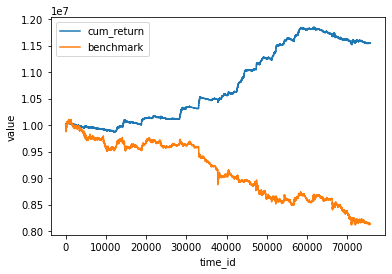

In [11]:
# 绘制资金曲线（目前可获取的数据有资金曲线、交易记录、风险度曲线、交易费用、持仓量和可用持仓量，这里只展示资金曲线和风险度曲线）
# 与做长线不同，高频交易追求的是稳定的盈利而非大起大落，所以回撤一定要控制好，即使会牺牲掉部分超额收益

import matplotlib.pyplot as plt

user_account, benchmark = exe.user_account.val_hist, exe.benchmark.val_hist
acc_hist, ben_hist = pd.DataFrame({'value': user_account}), pd.DataFrame({'value': benchmark})

plt.plot(acc_hist, label='cum_return')
plt.plot(ben_hist, label='benchmark')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()

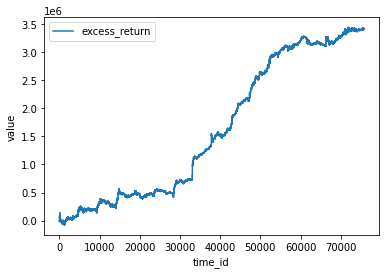

             value
75744  3417096.774


In [12]:
excess_return = acc_hist - ben_hist
plt.plot(excess_return, label='excess_return')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()
print(excess_return.iloc[-1:])

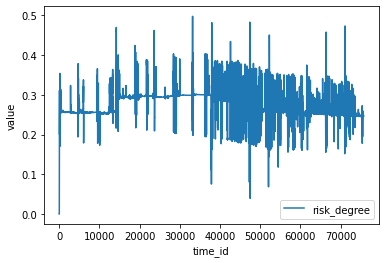

In [13]:
risk = pd.DataFrame({'risk': exe.user_account.risk_curve})

plt.plot(risk, label='risk_degree')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()

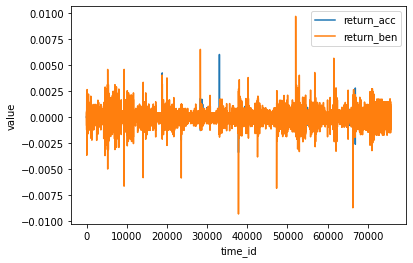

In [14]:
ret_acc, ret_ben = scutquant.price2ret(acc_hist['value'], 1, 0), scutquant.price2ret(ben_hist['value'], 1, 0)

plt.plot(ret_acc, label='return_acc')
plt.plot(ret_ben, label='return_ben')
plt.xlabel('time_id')
plt.ylabel('value')
plt.legend()
plt.show()